# Research of ads for the sale of apartments

The Yandex service data is at your disposal.Real estate — archive of ads for the sale of apartments in St. Petersburg and neighboring settlements for several years. You need to learn how to determine the market value of real estate. Your task is to set the parameters. This will allow you to build an automated system: it will track anomalies and fraudulent activity.

There are two types of data available for each apartment for sale. The first ones are entered by the user, the second ones are obtained automatically based on cartographic data. For example, the distance to the center, the airport, the nearest park and reservoir.

### Stage 1. Getting to know the data

       total_images  last_price  total_area first_day_exposition  rooms  \
2867              6   4500000.0       46.00  2015-01-22T00:00:00      1   
14475            13  10440000.0       70.81  2018-12-18T00:00:00      2   
6677             15   6050000.0       64.10  2018-08-29T00:00:00      3   
11534            20   5400000.0       55.00  2019-03-18T00:00:00      3   
8477              7   9500000.0       93.00  2017-01-23T00:00:00      3   
10280            20   3950000.0       61.10  2017-07-05T00:00:00      2   
19799            12   7500000.0       59.00  2019-02-19T00:00:00      3   
4424             11   6350000.0       43.40  2019-04-16T00:00:00      1   
16661             2   1249000.0       34.00  2018-01-21T00:00:00      1   
6851              4    700000.0       33.00  2018-09-11T00:00:00      1   
5529             13   2250000.0       28.70  2017-04-17T00:00:00      1   
10661             7   2600000.0       34.40  2016-12-19T00:00:00      1   
2791             11   250

array([[<AxesSubplot:title={'center':'total_images'}>,
        <AxesSubplot:title={'center':'last_price'}>,
        <AxesSubplot:title={'center':'total_area'}>,
        <AxesSubplot:title={'center':'rooms'}>],
       [<AxesSubplot:title={'center':'ceiling_height'}>,
        <AxesSubplot:title={'center':'floors_total'}>,
        <AxesSubplot:title={'center':'living_area'}>,
        <AxesSubplot:title={'center':'floor'}>],
       [<AxesSubplot:title={'center':'kitchen_area'}>,
        <AxesSubplot:title={'center':'balcony'}>,
        <AxesSubplot:title={'center':'airports_nearest'}>,
        <AxesSubplot:title={'center':'cityCenters_nearest'}>],
       [<AxesSubplot:title={'center':'parks_around3000'}>,
        <AxesSubplot:title={'center':'parks_nearest'}>,
        <AxesSubplot:title={'center':'ponds_around3000'}>,
        <AxesSubplot:title={'center':'ponds_nearest'}>],
       [<AxesSubplot:title={'center':'days_exposition'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], d

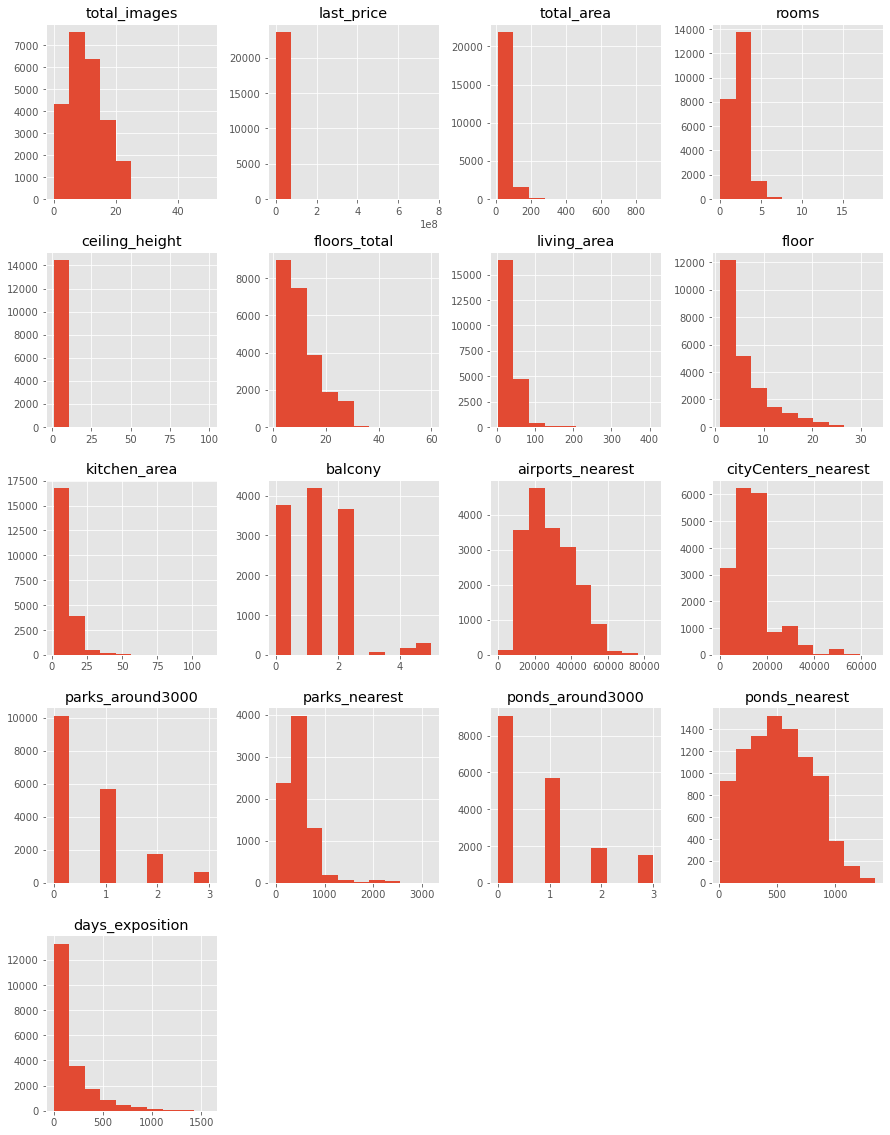

In [208]:
#import libraries and look at a random selection based on data
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
plt.style.use('ggplot')
from matplotlib.pyplot import figure


data = pd.read_csv('real_estate_data.csv', sep = '\t')
print(data.sample(20))
data.info()

data.hist(figsize=(15, 20))

**Main conclusions on stage 1**

There are some problems visible right away:

- missing values;
- low-quality column names;
- incorrect data types

### Data preprocessing

In [209]:
data = data.rename(columns = {'cityCenters_nearest': 'city_centers_nearest'})
print(data.isna().sum()) 

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
city_centers_nearest     5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64


A large number of omissions were detected in the following columns: is_apartment, balcony, park_nearest, points_nearest. Probably, zero values are missing in the columns 'balcony' and 'is_apartment': there is no balcony in the apartments and these are not apartments. Some of the missing values can be filled with median values: the living area, for example, depends on the number of rooms. 
Data with omissions in 'floors_total', 'locality_name' can be removed: there are not so many of them, but the absence will not give us anything.

In [210]:
data['balcony'] = data['balcony'].fillna(0)
data['is_apartment'] = data['is_apartment'].fillna(False)

data= data.dropna(subset=['locality_name']).reset_index(drop=True)
data= data.dropna(subset=['floors_total']).reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23565 entries, 0 to 23564
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23565 non-null  int64  
 1   last_price            23565 non-null  float64
 2   total_area            23565 non-null  float64
 3   first_day_exposition  23565 non-null  object 
 4   rooms                 23565 non-null  int64  
 5   ceiling_height        14481 non-null  float64
 6   floors_total          23565 non-null  float64
 7   living_area           21700 non-null  float64
 8   floor                 23565 non-null  int64  
 9   is_apartment          23565 non-null  bool   
 10  studio                23565 non-null  bool   
 11  open_plan             23565 non-null  bool   
 12  kitchen_area          21343 non-null  float64
 13  balcony               23565 non-null  float64
 14  locality_name         23565 non-null  object 
 15  airports_nearest   

In [211]:
number_rooms = list(data['rooms'].unique()) # we determine the unique values of the rooms for the next cycle

#fill in the gaps in the living area and kitchen area depending on the number of rooms
for room in number_rooms:
    median_living_area = data[data['rooms'] == room]['living_area'].median()
    data.loc[(data['rooms'] == room)&(data['living_area'].isna()), 'living_area'] = median_living_area
    
    median_kitchen_area = data[data['rooms'] == room]['kitchen_area'].median()
    data.loc[(data['rooms'] == room)&(data['kitchen_area'].isna()), 'kitchen_area'] = median_kitchen_area
    
    
locality_name_unique = list(data['locality_name'].unique()) # we determine the unique values of localities for the next cycle

#fill in the gaps depending on the name of the locality (with the exception of St. Petersburg)
for locality in locality_name_unique:
    if locality!='Санкт-Петербург':
        median_airports_nearest = data[data['locality_name'] == locality]['airports_nearest'].median()
        data.loc[(data['locality_name'] == locality)&(data['airports_nearest'].isna()), 'airports_nearest'] = median_airports_nearest
        
        median_city_centers_nearest = data[data['locality_name'] == locality]['city_centers_nearest'].median()
        data.loc[(data['locality_name'] == locality)&(data['city_centers_nearest'].isna()), 'city_centers_nearest'] = median_city_centers_nearest
        
        median_parks_around3000 = data[data['locality_name'] == locality]['parks_around3000'].median()
        data.loc[(data['locality_name'] == locality)&(data['parks_around3000'].isna()), 'parks_around3000'] = median_parks_around3000
        
        median_parks_nearest = data[data['locality_name'] == locality]['parks_nearest'].median()
        data.loc[(data['locality_name'] == locality)&(data['parks_nearest'].isna()), 'parks_nearest'] = median_parks_nearest
        
        median_ponds_around3000 = data[data['locality_name'] == locality]['ponds_around3000'].median()
        data.loc[(data['locality_name'] == locality)&(data['ponds_around3000'].isna()), 'ponds_around3000'] = median_ponds_around3000
        
        median_ponds_nearest = data[data['locality_name'] == locality]['ponds_nearest'].median()
        data.loc[(data['locality_name'] == locality)&(data['ponds_nearest'].isna()), 'ponds_nearest'] = median_ponds_nearest
print(data.isna().sum()) #number of gaps by columns

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9084
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area              194
balcony                     0
locality_name               0
airports_nearest         5516
city_centers_nearest     5492
parks_around3000         5492
parks_nearest           14386
ponds_around3000         5492
ponds_nearest           13232
days_exposition          3171
dtype: int64


Some gaps were filled in, but not all: most likely, there are a lot of missing values in the dataset in St. Petersburg, as well as in localities that are rare and with Nan (which makes it difficult to determine the median value).
Mostly cartographic data is missing, not information added by the owner of the property. Such data is detected automatically, so omissions most likely mean that the automatic detection did not work

In [212]:
data.info()  #let's print the information about the data types in the columns again

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23565 entries, 0 to 23564
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23565 non-null  int64  
 1   last_price            23565 non-null  float64
 2   total_area            23565 non-null  float64
 3   first_day_exposition  23565 non-null  object 
 4   rooms                 23565 non-null  int64  
 5   ceiling_height        14481 non-null  float64
 6   floors_total          23565 non-null  float64
 7   living_area           23565 non-null  float64
 8   floor                 23565 non-null  int64  
 9   is_apartment          23565 non-null  bool   
 10  studio                23565 non-null  bool   
 11  open_plan             23565 non-null  bool   
 12  kitchen_area          23371 non-null  float64
 13  balcony               23565 non-null  float64
 14  locality_name         23565 non-null  object 
 15  airports_nearest   

### Changing data types 
Dates are written as strings. You need to change and also make the number of balconies integer

In [213]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

data ['balcony'] = data ['balcony'].astype('int')


data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23565 entries, 0 to 23564
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23565 non-null  int64         
 1   last_price            23565 non-null  float64       
 2   total_area            23565 non-null  float64       
 3   first_day_exposition  23565 non-null  datetime64[ns]
 4   rooms                 23565 non-null  int64         
 5   ceiling_height        14481 non-null  float64       
 6   floors_total          23565 non-null  float64       
 7   living_area           23565 non-null  float64       
 8   floor                 23565 non-null  int64         
 9   is_apartment          23565 non-null  bool          
 10  studio                23565 non-null  bool          
 11  open_plan             23565 non-null  bool          
 12  kitchen_area          23371 non-null  float64       
 13  balcony         

### duplicates

In [214]:
print(data.duplicated().sum())# counting explicit duplicates
data['locality_name'] = data['locality_name'].str.lower()  #analysis of implicit duplicates
print(data['locality_name'].sort_values().unique())

print('Number of localities:', len(data['locality_name'].sort_values().unique()))


0
['бокситогорск' 'волосово' 'волхов' 'всеволожск' 'выборг' 'высоцк'
 'гатчина' 'городской поселок большая ижора' 'городской поселок янино-1'
 'городской посёлок будогощь' 'городской посёлок виллози'
 'городской посёлок лесогорский' 'городской посёлок мга'
 'городской посёлок назия' 'городской посёлок новоселье'
 'городской посёлок павлово' 'городской посёлок рощино'
 'городской посёлок свирьстрой' 'городской посёлок советский'
 'городской посёлок фёдоровское' 'городской посёлок янино-1'
 'деревня агалатово' 'деревня аро' 'деревня батово' 'деревня бегуницы'
 'деревня белогорка' 'деревня большая вруда' 'деревня большая пустомержа'
 'деревня большие колпаны' 'деревня большое рейзино'
 'деревня большой сабск' 'деревня бор' 'деревня борисова грива'
 'деревня ваганово' 'деревня вартемяги' 'деревня вахнова кара'
 'деревня выскатка' 'деревня гарболово' 'деревня глинка'
 'деревня горбунки' 'деревня гостилицы' 'деревня заклинье'
 'деревня заневка' 'деревня зимитицы' 'деревня извара' 'деревня ис

There are many unique localities (364), there are obvious duplicates associated with the use of the letters Е, Ё, however, there are doubts that it makes sense to manually select duplicates, given the number and purpose of the study. Let's check the distribution by city

In [215]:
data['locality_name'] = data['locality_name'].str.replace('ё', 'е', regex=True)

print(data['locality_name'].value_counts()) #checking the distribution of data by city
print('Number of localities', len(data['locality_name'].sort_values().unique()))

санкт-петербург                     15651
поселок мурино                        552
поселок шушары                        439
всеволожск                            398
пушкин                                369
                                    ...  
поселок левашово                        1
садовое товарищество новая ропша        1
деревня шпаньково                       1
деревня курковицы                       1
поселок дзержинского                    1
Name: locality_name, Length: 330, dtype: int64
Number of localities 330


A little more than 30 takes were removed. It makes sense to add a new column, given the type of locality (city, town, etc.)

In [216]:
def classification_locality (row):  
    if 'санкт-петербург' in row:
        return 'city'
    elif 'сел' in row or 'товарищ' in row:
        return 'village'
    else:
        return 'town'
data['classification_locality'] = data['locality_name'].apply(classification_locality)

print(data['classification_locality'].value_counts())  

city       15651
town        4992
village     2922
Name: classification_locality, dtype: int64


#### Let's analyze the anomalies in the columns

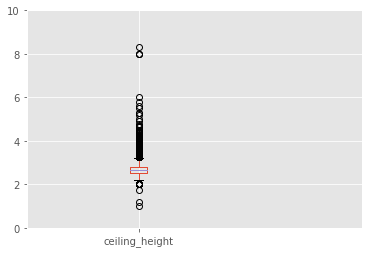

<AxesSubplot:>

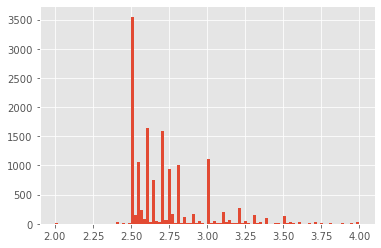

In [217]:
plt.xlim(0, 3)
plt.ylim(0, 10)
data.boxplot(['ceiling_height'])
plt.show()


data['ceiling_height'].hist(bins=100, range=(2,4))

the ceiling height variation from 1 m to 100 suggests anomalies, but the good news is that there are not so many of them, judging by the quartiles. The boxplot shows that there are outliers from above and below.

In [218]:
#let's look at outliers across all columns, 
# paying special attention to the data provided by customers (not cartographic data)
display(data.describe())


,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23565.000000,2.356500e+04,23565.000000,23565.000000,14481.000000,23565.000000,23565.000000,23565.000000,23371.000000,23565.000000,18049.000000,18073.000000,18073.000000,9179.000000,18073.000000,10333.000000,20394.000000
mean,9.878421,6.540058e+06,60.322824,2.070656,2.771283,10.675875,34.324899,5.878124,10.454371,0.593677,28797.960801,14201.752476,0.611409,490.441497,0.769380,515.566680,180.741395
std,5.681156,1.091093e+07,35.657060,1.078591,1.261983,6.594823,21.722006,4.871485,5.665974,0.960660,12634.794938,8623.758031,0.802067,324.514221,0.938597,264.045707,219.732782
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.510000,5.000000,18.400000,2.000000,7.300000,0.000000,18557.000000,9238.000000,0.000000,307.500000,0.000000,311.000000,45.000000
50%,9.000000,4.646000e+06,52.000000,2.000000,2.650000,9.000000,30.300000,4.000000,9.000000,0.000000,26755.000000,13101.000000,0.000000,440.000000,1.000000,509.000000,95.000000
75%,14.000000,6.790000e+06,69.700000,3.000000,2.800000,16.000000,42.700000,8.000000,11.500000,1.000000,37273.000000,16293.000000,1.000000,618.000000,1.000000,692.000000,231.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


In [219]:
# Исправление значений у квартир с выстой потолка более и равной 25 м
data.loc[data['ceiling_height'] >= 25, 'ceiling_height'] /= 10
q1_ceiling = data['ceiling_height'].quantile(0.25)
q3_ceiling = data['ceiling_height'].quantile(0.75)
iqr_ceiling = q3_ceiling - q1_ceiling
max_ceiling = q3_ceiling + 1.5 * iqr_ceiling

print('First quartile:', q1_ceiling, 'Third quartile:',  q3_ceiling, 'Interquartile range:',iqr_ceiling, 'Maximum ceiling height without outliers:', max_ceiling)




First quartile: 2.51 Third quartile: 2.8 Interquartile range: 0.29000000000000004 Maximum ceiling height without outliers: 3.235


We will leave the missing values in the data, because there are a lot of them and those that are between 2.5 (ceilings cannot be smaller in accordance with the construction rules) and 3.3 m

In [220]:
data = data.loc[(data['ceiling_height'].isna()) | ((data['ceiling_height'] >= 2.5) \
                              & (data['ceiling_height'] <= 3.3))]

print(data.pivot_table(index='classification_locality', values='ceiling_height', aggfunc='median'))



                         ceiling_height
classification_locality                
city                               2.68
town                               2.60
village                            2.60


Fill in the data on missed ceilings with a median value depending on the type of locality

-0.5001800054147827
0.251273015976312
0.43460171337149217
-0.0751307561853234
0.38081143895066
0.4008342278619433


<AxesSubplot:xlabel='city_centers_nearest', ylabel='ceiling_height'>

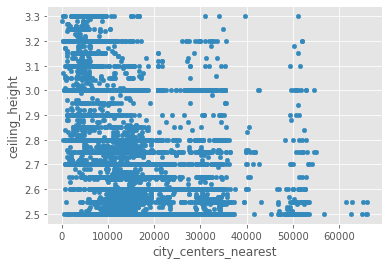

In [221]:
#Let's first check the correlation of the ceiling height in St. Petersburg from other parameters
print(data.query('classification_locality=="city"')['ceiling_height'].corr(data['city_centers_nearest']))
print(data.query('classification_locality=="city"')['ceiling_height'].corr(data['rooms']))
print(data.query('classification_locality=="city"')['ceiling_height'].corr(data['total_area']))
print(data.query('classification_locality=="city"')['ceiling_height'].corr(data['floors_total']))
print(data.query('classification_locality=="city"')['ceiling_height'].corr(data['living_area']))
print(data.query('classification_locality=="city"')['ceiling_height'].corr(data['kitchen_area']))



# Visual check of the correlation of the values of the ceiling_height column with the distance from the center
data.plot(x='city_centers_nearest', y='ceiling_height', kind='scatter')

In [222]:
#Let's build a table of the dependence of the median ceiling height on the distance from the center of St. Petersburg
df_locality_ceiling_spb = (
data
    .query('ceiling_height > 2.5 and ceiling_height < 3.3 and classification_locality == "city"')
    .groupby('city_centers_nearest')['ceiling_height']
    .median()
    .reset_index()
)

df_locality_ceiling_spb.head()

,city_centers_nearest,ceiling_height
0,181.0,3.28
1,318.0,3.20
2,329.0,3.07
3,387.0,3.20
4,399.0,2.80


Text(0.5, 0, 'Distance from the center (km)')

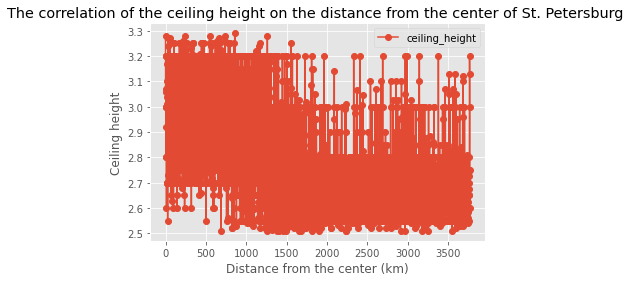

In [223]:
ax = df_locality_ceiling_spb.plot(y='ceiling_height', style='o-')

ax.set_title('The correlation of the ceiling height on the distance from the center of St. Petersburg ', ha='center', fontsize='x-large')
ax.set_ylabel('Ceiling height', fontsize='large')
ax.set_xlabel('Distance from the center (km)', fontsize='large')

In [224]:
# the function returns the median value of the ceiling height for the distance from the center 
# if there are no ceiling height values in the summary table, return the value 2.68 (median for St. Petersburg)

def find_ceiling_height_value(city_centers_nearest)->float:
    median_group = df_locality_ceiling_spb.query(
        'city_centers_nearest == city_centers_nearest'
    )['ceiling_height']
    if median_group.empty:
        return 2.68
    else:
        return median_group.values[0]

In [225]:
classification_locality_unique = list(data['classification_locality'].unique()) 
#fill in the gaps depending on the name of the locality
for locality in locality_name_unique:
    median_ceiling = data[data['classification_locality'] == locality]['ceiling_height'].median()
    data.loc[(data['classification_locality'] == locality)&(data['ceiling_height'].isna()), 'ceiling_height'] = median_ceiling
data['ceiling_height'].isnull().sum()

9084

In [226]:

def floor_status(row):
    if row['floor'] == 1:
        return 'first'
    elif row['floor'] == row['floors_total']:
        return 'last'
    else:
        return 'other'
data['floor_status'] = data.apply(floor_status, axis=1)

In [227]:
# Add the price per square meter
data['price_per_meter'] = data['last_price'] / data['total_area']
data['price_per_meter'] = data['price_per_meter'].round(decimals=2)
print(data.head())

   total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0       108.0           2019-03-07      3   
1             7   3350000.0        40.4           2018-12-04      1   
2            10   5196000.0        56.0           2015-08-20      2   
3             0  64900000.0       159.0           2015-07-24      3   
4             2  10000000.0       100.0           2018-06-19      2   

   ceiling_height  floors_total  living_area  floor  is_apartment  ...  \
0            2.70          16.0         51.0      8         False  ...   
1             NaN          11.0         18.6      1         False  ...   
2             NaN           5.0         34.3      4         False  ...   
3             NaN          14.0         45.0      9         False  ...   
4            3.03          14.0         32.0     13         False  ...   

   airports_nearest  city_centers_nearest  parks_around3000  parks_nearest  \
0           18863.0               16028.0         

In [228]:
# Add columns with day, month and year
data['day_of_week_exposition'] = data['first_day_exposition'].dt.day_name()
data['month_exposition'] = data['first_day_exposition'].dt.month_name()
data['year_exposition'] = data['first_day_exposition'].dt.year
print(data.head(10))

   total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0      108.00           2019-03-07      3   
1             7   3350000.0       40.40           2018-12-04      1   
2            10   5196000.0       56.00           2015-08-20      2   
3             0  64900000.0      159.00           2015-07-24      3   
4             2  10000000.0      100.00           2018-06-19      2   
5            10   2890000.0       30.40           2018-09-10      1   
6             6   3700000.0       37.30           2017-11-02      1   
7             5   7915000.0       71.60           2019-04-18      2   
8            20   2900000.0       33.16           2018-05-23      1   
9            18   5400000.0       61.00           2017-02-26      3   

   ceiling_height  floors_total  living_area  floor  is_apartment  ...  \
0            2.70          16.0        51.00      8         False  ...   
1             NaN          11.0        18.60      1         False  ...

In [229]:
#we will add with the day of the week of publication
def days_of_week(row):
    if row['day_of_week_exposition'] == "Monday":
        return 0
    elif row['day_of_week_exposition'] == "Tuesday":
        return 1
    elif row['day_of_week_exposition'] == "Wednesday":
        return 2
    elif row['day_of_week_exposition'] == "Thursday":
        return 3
    elif row['day_of_week_exposition'] == "Friday":
        return 4
    elif row['day_of_week_exposition'] == "Saturday":
        return 5
    else:
        return 6
data['days_of_week'] = data.apply(days_of_week, axis=1)
display(data.head())

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,classification_locality,floor_status,price_per_meter,day_of_week_exposition,month_exposition,year_exposition,days_of_week
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.0,8,False,...,2.0,755.0,NaN,city,other,120370.37,Thursday,March,2019,3
1,7,3350000.0,40.4,2018-12-04,1,NaN,11.0,18.6,1,False,...,0.0,584.5,81.0,village,first,82920.79,Tuesday,December,2018,1
2,10,5196000.0,56.0,2015-08-20,2,NaN,5.0,34.3,4,False,...,2.0,574.0,558.0,city,other,92785.71,Thursday,August,2015,3
3,0,64900000.0,159.0,2015-07-24,3,NaN,14.0,45.0,9,False,...,3.0,234.0,424.0,city,other,408176.10,Friday,July,2015,4
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.0,13,False,...,1.0,48.0,121.0,city,other,100000.00,Tuesday,June,2018,1


In [230]:
# Remove meters from columns with ponds, airports and city centers, bring everything to kilometers
data['city_centers_nearest_km'] = data['city_centers_nearest'] / 1000
data['airports_nearest_km'] = data['airports_nearest'] / 1000
data['parks_nearest_km'] = data['parks_nearest'] / 1000
data['ponds_nearest_km'] = data['ponds_nearest'] / 1000

In [231]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22906 entries, 0 to 23564
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   total_images             22906 non-null  int64         
 1   last_price               22906 non-null  float64       
 2   total_area               22906 non-null  float64       
 3   first_day_exposition     22906 non-null  datetime64[ns]
 4   rooms                    22906 non-null  int64         
 5   ceiling_height           13822 non-null  float64       
 6   floors_total             22906 non-null  float64       
 7   living_area              22906 non-null  float64       
 8   floor                    22906 non-null  int64         
 9   is_apartment             22906 non-null  bool          
 10  studio                   22906 non-null  bool          
 11  open_plan                22906 non-null  bool          
 12  kitchen_area             22716 n

## Step 2 Exploratory data analysis 

Let's look at some parameters: total area; living area; kitchen area; object price; number of rooms; ceiling height;
apartment floor; type of apartment floor ("first", "last", "other"); total number of floors in the house; distance to the city center in meters; distance to the nearest airport; distance to the nearest park; day and month of publication of the announcement. 

We automate the construction of histograms for each parameter. Let's see what the span diagrams look like for the studied data and get rid of outliers.

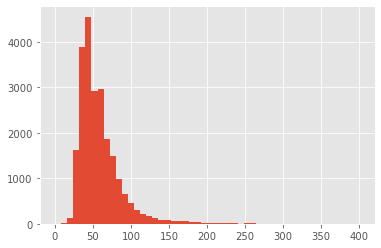

In [232]:
def draw_hist(col, xmin, xmax):
    data[col].hist(bins=50, range=(xmin, xmax))
def draw_boxplot(col, ymin=-50, ymax=200):
    plt.ylim(ymin, ymax)
    data.boxplot(col)
draw_hist('total_area', 0, 400)

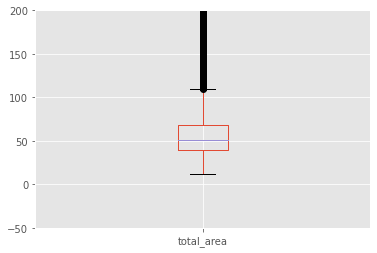

In [233]:
draw_boxplot('total_area')

The spread of normal values starts at about 15 sq.m and ends at 120 sq.m. Let's get rid of all the missing values.

In [234]:
print('Number of outliers by total area:', data.query('120>total_area<15')['total_area'].count())

Number of outliers by total area: 5


In [235]:
data = data.query('total_area>=15 and total_area<=120')

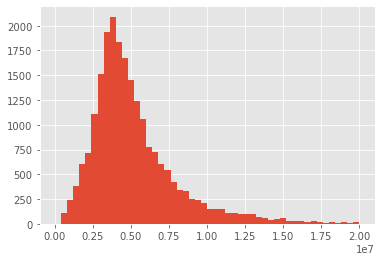

In [236]:
draw_hist('last_price', 0, 20000000)

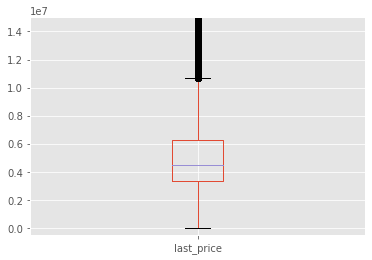

In [237]:
draw_boxplot('last_price', -500000, 15000000)

Normal values are in the range from zero to 11 million. We will leave only them.

In [238]:
data = data.query('last_price>10000 and last_price<=11000000')

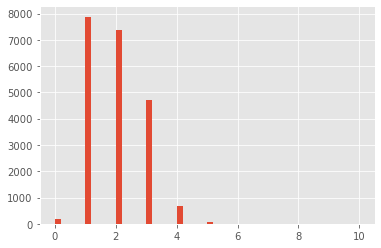

In [239]:
draw_hist('rooms', 0, 10)

Most apartments have 1-3 rooms. We see a small segment with zero rooms. These are probably studios.

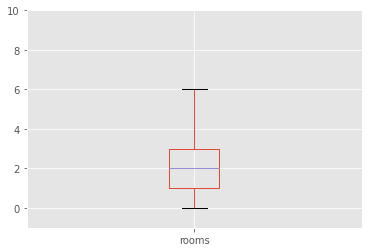

In [240]:
draw_boxplot('rooms', -1, 10)

We will leave only apartments with fewer than 7 rooms

In [241]:
data = data.query('rooms>=0 and rooms <7')

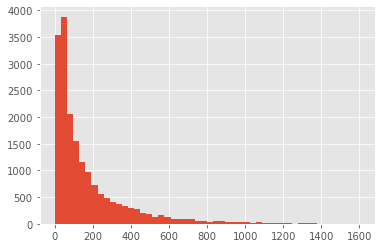

In [242]:
draw_hist('days_exposition', 0, 1600)

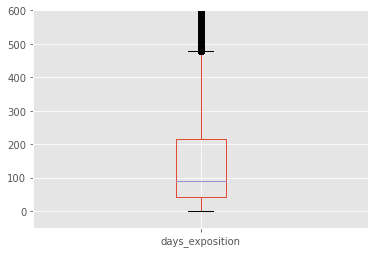

In [243]:
draw_boxplot('days_exposition', -50, 600)

In [244]:
#let's remove unnecessary data based on quartiles. We will remove apartments that are sold in less than 1 day, as well as longer than 478 days(q3+1.5*iqr)
data['days_exposition'].describe()

count    18344.000000
mean       171.077846
std        208.598379
min          1.000000
25%         43.000000
50%         91.000000
75%        217.000000
max       1580.000000
Name: days_exposition, dtype: float64

<AxesSubplot:>

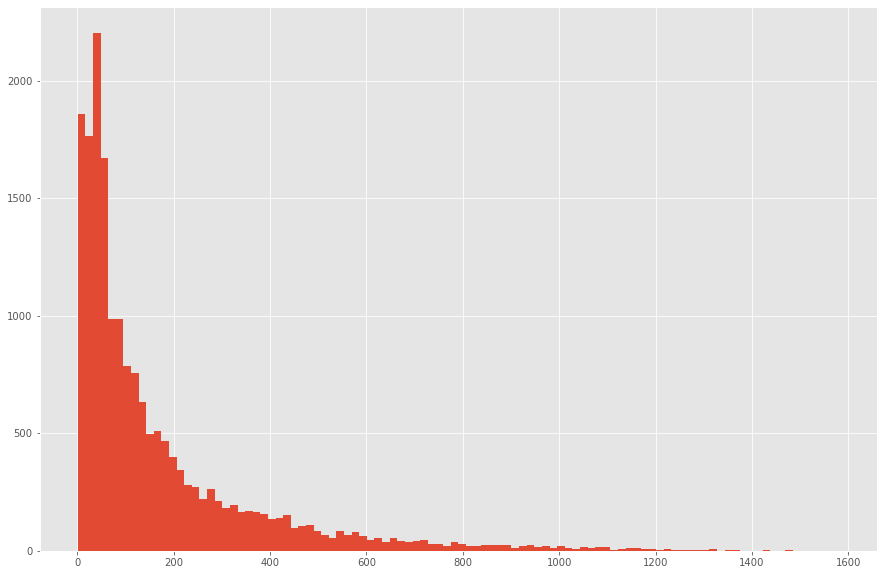

In [245]:
data['days_exposition'].hist(bins=100, figsize=(15, 10))

In [246]:
data.pivot_table(index='classification_locality', values='days_exposition', aggfunc=['median', 'mean'])

,median,mean
,days_exposition,days_exposition
classification_locality,,
city,89.0,168.521214
town,95.0,180.626334
village,94.0,167.337250


It is obvious that in any such sample there are outliers both at the bottom (the seller put the object up for sale and immediately changed his mind) and at the top (artificial ads with an inflated price that hang for a long time and "form" the market price). At the same time, these values indicate that half of the ads are completed with a transaction within 91 (second quartile, median) days or less.

To the category of "fast" sales, it is advisable to include all sales within up to 43 days (first quartile) from the date of placement, "long" sales - over 217 (third quartile) days of placement. Average time - 171 days (average value)

Note that in St. Petersburg apartments are sold a little faster

**Evaluation of the main parameters of the apartment**
We will study the following main parameters of apartments: area, price, number of rooms, ceiling height, floor of the apartment, type of floor of the apartment ("first", "last", "other"), total number of floors in the house, distance to the city center in meters, distance to the nearest airport, distance to the nearest park, the day and month of publication of the announcement

At the stage of pre-processing, the parameters of the living area and the kitchen area, the ceiling height and the number of rooms were studied in detail.

In [247]:
# there are a lot of parameters, histograms too, let's make this process a little easier
#function for displaying the parameter distribution as a histogram:
# df_to_plot - dataframe of the source data
# param - calculation parameters
# range_min - minimum value of the parameter (display range)
# range_max - maximum value of the parameter (display range)
# bins - number of bins
# title - the general name of the chart


def plot_param_single_hist(
    df_to_plot, 
    param, 
    range_min, 
    range_max,
    bins,
    title,
    x_label,
    y_label
):
    
    ax = df_to_plot[param].plot(
        x=param, 
        grid=True, 
        kind='hist', 
        range=(range_min, range_max), 
        bins=bins
    )

    ax.set_title(title, fontsize='x-large')
    ax.set_xlabel(x_label, fontsize='large')
    ax.set_ylabel(y_label, fontsize='large')
#Let's build a histogram of the distribution of the values of the total area on all the source data.


# function for the joint display of the parameter distribution in the form of a histogram and a span diagram
# df_to_plot - dataframe of the source data
# param - calculation parameters
# range_min - minimum value of the parameter (display range)
# range_max - maximum value of the parameter (display range)
# bins - number of bins
# title - the general name of the chart


def plot_param_hist_boxplot(
    df_to_plot, 
    param, 
    range_min, 
    range_max,
    bins,
    title,
    x_label,
    y_label
):
    fig, (ax1, ax2) = plt.subplots(
        nrows=2, 
        ncols=1, 
        sharex=True,
        figsize=(14, 10), 
        gridspec_kw={'height_ratios': [2.5, 1]}
    )

    df_to_plot.hist(
        param, 
        range=(range_min, range_max), 
        bins=bins, 
        ax=ax1
    )

    plt.xlim(range_min, range_max)
    plt.ylim(0, 2) 

    df_to_plot[param].plot(
        x=param, 
        vert=False, 
        kind='box', 
        grid=True, 
        ax=ax2
    )

    ax1.set_title('')
    ax2.set_title('')

    plt.suptitle(title, ha='center', fontsize='xx-large')
    ax1.set_ylabel(y_label, fontsize='x-large')
    ax2.set_xlabel(x_label, fontsize='x-large')


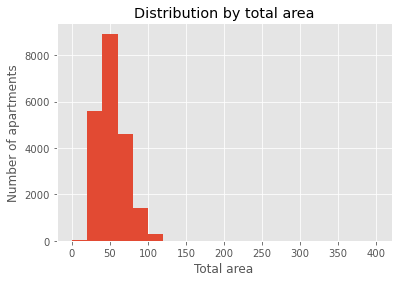

In [248]:
plot_param_single_hist(
    data,
    'total_area',
    0,
    400,
    20,
    'Distribution by total area',
    'Total area',
    'Number of apartments'
)
#Построим гистограмму распределения значений общей площади в диапазоне от 0 до 200.

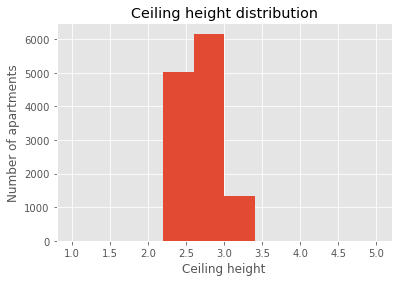

In [249]:
plot_param_single_hist(
    data,
    'ceiling_height',
    1,
    5,
    10,
    'Ceiling height distribution',
    'Ceiling height',
    'Number of apartments'
)



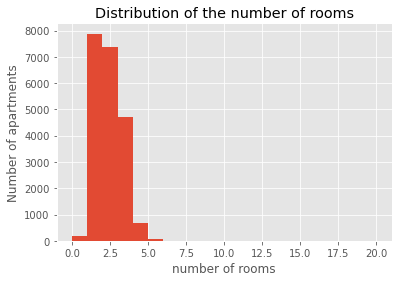

In [250]:
plot_param_single_hist(
    data,
    'rooms',
    0,
    20,
    20,
    'Distribution of the number of rooms',
    'number of rooms',
    'Number of apartments'
)

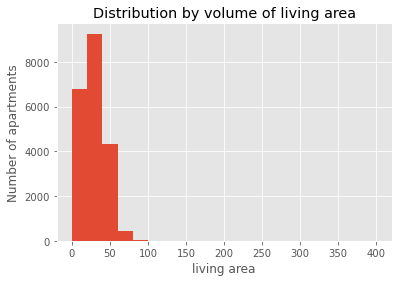

In [251]:
plot_param_single_hist(
    data,
    'living_area',
    0,
    400,
    20,
    'Distribution by volume of living area',
    'living area',
    'Number of apartments'
)

In [252]:
plot_param_single_hist(
    data,
    'kitchen_area',
    0,
    100,
    20,
    'Distribution by the kitchen area',
    'kitchen area,
    'Number of apartments'
)

SyntaxError: EOL while scanning string literal (1036005378.py, line 8)

In [ ]:
plot_param_single_hist(
    data,
    'airports_nearest',
    0,
    100000,
    20,
    'Distribution by distance to the airport',
    'Distance to the airport',
    'Number of apartments'
)


In [ ]:
plot_param_single_hist(
    data,
    'parks_nearest',
    0,
    4000,
    20,
    'Distribution by distance to the park',
    'distance to the park',
    'Number of apartments'
)

In [ ]:
plot_param_single_hist(
    data,
    'floor',
    1,
    35,
    20,
    'Distribution by floor',
    'floor',
    'number of apartments'
)

In [ ]:
plot_param_single_hist(
    data,
    'floors_total',
    1,
    60,
    20,
    'Distribution by the total number of floors in the house',
    'Number of floors in the house',
    'Number of apartments'
)

In [ ]:
plot_param_single_hist(
    data,
    'city_centers_nearest',
    200,
    60000,
    20,
    'Distribution by distance from the center',
    'Distance from the center',
    'Number of apartments'
)

In [ ]:
plot_param_single_hist(
    data,
    'last_price',
    1.219000e+04,
    1.100000e+07,
    20,
    'The cost of real estate',
    'Cost',
    'Number of apartments'
)


In [ ]:
data['day_of_week_exposition'].value_counts().plot(kind='barh')

In [ ]:
data['floor_status'].value_counts().plot(kind='barh')

In [ ]:

data['month_exposition'].value_counts().plot(kind='barh')

In [ ]:

data['year_exposition'].value_counts().plot(kind='barh')

##### Conclusion_step 2:
as the histograms demonstrate, the data presented in the table by area, cost, number of rooms, ceiling height, apartment floor, the total number of floors in the house as a whole are close to the normal distribution after data preprocessing. 
There are several peaks in the number of floors, but this is due to the peculiarities of the planned development of the town (5-storey, 9-storey, etc.)
Cartographic data, i.e. data calculated automatically, also do not cause doubts.
More often they sell apartments not on the first and not on the last floor
The publication data can also hardly be questioned: in 2014 the service was at the beginning of its development, by 2018 the number of ads increased.
The distribution of the number of ads by month proves only that ads are placed less frequently on weekends: on Saturdays and Sundays there is a clear failure, similarly in December, January and May.

We can proceed to the evaluation of correlations.

##### step 3. Factors affecting the cost of an apartment

In [ ]:
# Estimation of the correlation of the apartment price with the total area

data.plot(y='last_price',x='total_area',kind='scatter', figsize=(12,6))
plt.title('How does the total area affect the price of an apartment', fontsize=15)

data['total_area'].corr(data['last_price'])

In [ ]:
# Estimation of the correlation of the apartment price with the living area
data.plot(y='last_price',x='living_area',kind='scatter', figsize=(12,6))
plt.title('How does the living area affect the price of an apartment', fontsize=15)
data['living_area'].corr(data['last_price'])

In [ ]:
# Estimation of the correlation of the apartment price with the kitchen area
data.plot(y='last_price',x='kitchen_area',kind='scatter', figsize=(12,6))
plt.title('How does the kitchen area affect the price of an apartment', fontsize=15)
data['kitchen_area'].corr(data['last_price'])

In [ ]:
# Estimation of the correlation of the apartment price with the number of rooms
data.plot(y='last_price',x='rooms',kind='scatter', figsize=(12,6))
plt.title('How does the number of rooms affect the price of an apartment', fontsize=15)


data['rooms'].corr(data['last_price'])


In [ ]:
display(data.pivot_table( index='rooms', values='last_price', aggfunc='mean'))

In [ ]:
# Estimation of the correlation of the apartment price with the floor

data.plot(y='last_price',x='floor_status',kind='scatter', figsize=(12,6))
plt.title('How does the floor affect the price of the apartment', fontsize=15)

#Let's try to see which floor apartment is more expensive
display(data.pivot_table( index='floor_status', values='last_price', aggfunc='mean'))

In [ ]:
# Estimation of the correlation of the apartment price with the date of placement:
data.plot(y='last_price',x='day_of_week_exposition',kind='scatter', figsize=(12,6))
plt.title('How does the day of the week affect the price of an apartment', fontsize=15)

display(data.pivot_table( index='day_of_week_exposition', values='last_price', aggfunc='mean'))

In [ ]:

data.plot(y='last_price',x='month_exposition',kind='scatter', figsize=(12,6))
plt.title('Как месяц влияет на цену квартиры', fontsize=15)

display(data.pivot_table( index='month_exposition', values='last_price', aggfunc='mean'))

In [ ]:

data.plot(y='last_price',x='year_exposition',kind='scatter', figsize=(12,6))
plt.title('Как год объявления влияет на цену квартиры', fontsize=15)
data['year_exposition'].corr(data['last_price'])
display(data.pivot_table( index='year_exposition', values='last_price', aggfunc='mean'))

**Conclusion_step 3** : most of all, the final cost is affected (in descending order) by: total area (the highest coefficient of correlation), living area, kitchen. The cheapest real estate is on the first and last floors. There is no difference on the days of the week, but in May and June real estate is sold the cheapest, in April it is more expensive. However, the difference is not so obvious. In addition, prices were slightly lower in 2016-2018, and prices have been rising since 2019

In [ ]:
# However, with the increase in the number of rooms, the price per sq.m falls. And if we consider the total area, then the cost per square meter decreases with each meter as the area increases after 60 sq.m.

distance_from_center = data.query('city_centers_nearest != -1')
display(distance_from_center['price_per_meter'].corr(distance_from_center['city_centers_nearest']))
display(distance_from_center['last_price'].corr(distance_from_center['city_centers_nearest']))


The cost of real estate correlates less with the distance from the center than the price per square meter.

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(data[['last_price', 'total_area','rooms','living_area', 'kitchen_area', 'floor_status','city_centers_nearest']].corr(), annot=True, square=True, vmin=-1, vmax=1, center=0, ax=ax)

#### 10 localities with the largest number of ads

In [ ]:
#Let's choose 10 localities with the largest number of ads. Let's calculate the average price per square meter in these localities. Let's highlight the localities with the highest and lowest cost of housing.

locality_sq_m_price = data.loc[:, ['locality_name', 'price_per_meter']]
locality_sq_m_price = locality_sq_m_price.pivot_table(index='locality_name', values='price_per_meter', aggfunc=['count', 'mean'])
locality_sq_m_price.columns = ['count', 'mean_sq_m_price']
top10_locality = locality_sq_m_price.sort_values(by='count', ascending=False).head(10)
top10_locality.plot(y='count', kind='pie', figsize=(8, 8))
print(top10_locality)

The most expensive apartments are in St. Petersburg, Pushkin and the village of Kudrovo, and the cheapest in Vyborg, Vsevolozhsk and Gatchina

In [ ]:
data.groupby('classification_locality').agg({'price_per_meter':'mean'}).sort_values(by='price_per_meter')


In [ ]:
data.groupby('classification_locality').agg({'price_per_meter':'median'}).sort_values(by='price_per_meter')

In [ ]:
plot = data.boxplot('price_per_meter', by='classification_locality', figsize=(10,10))
plot.set_ylim(0,200000)

as expected: apartments are more expensive in St. Petersburg, but the difference between everything outside is almost not felt

##### City center
##### Assessment of the dependence of the apartment price on the distance from the center of St. Petersburg
We will study the offers of apartments in St. Petersburg, for which the distance to the city center is indicated, in order to assess the dependence of the apartment price on the distance from the center

In [ ]:
# Estimation of the distribution of the distance to the center

data.query('classification_locality == "city"')['city_centers_nearest_km'].hist(bins=60, figsize=(15, 10))

In [ ]:
#Let's make a cross-section of the city "St. Petersburg"
data_spb = data.query('locality_name == "санкт-петербург"')
print('The number of missing values in the city_center_nearest_km column:', data_spb['city_centers_nearest_km'].isnull().sum())
print('The total number of values in the city_centers_nearest_km column:', len(data_spb['city_centers_nearest_km']))



In [ ]:
#The cartographic data is filled almost completely, I can get rid of nan without loss
data_spb= data_spb.dropna(subset=['city_centers_nearest_km']).reset_index(drop=True)
data_spb.head()

In [ ]:
#using the pivot_table method, we calculate the average cost per 1 km
data_spb['city_centers_nearest_km'] = data_spb['city_centers_nearest_km'].round(0).astype(int)
data_spb['price_per_kilometer'] = data_spb['last_price']/data_spb['city_centers_nearest_km']
data_per_km = data_spb.pivot_table(index='city_centers_nearest_km', values='price_per_kilometer', aggfunc='mean')


In [ ]:
#for each kilometer, we calculate the average cost per square meter
data_spb.groupby('city_centers_nearest_km').agg({'price_per_meter' : 'mean'}).plot(grid=True, figsize=(10,10), style='o-')

Here you can see the decline after 8 kilometers, which is approximately the border of the central zone of St. Petersburg

In [ ]:
city_center_in_8_km_df = data_spb.query('city_centers_nearest_km <= 8')
print(len(city_center_in_8_km_df))

cor_in_center = city_center_in_8_km_df.corr()\
        .sort_values('last_price', ascending=False)\
        .filter(items = ['last_price'])\
        .reset_index()
cor_in_center.style.background_gradient('coolwarm')

In [ ]:
city_center_out_8_km_df = data_spb.query('city_centers_nearest_km > 8')
cor_out_center = city_center_out_8_km_df.corr()\
        .sort_values('last_price', ascending=False)\
        .filter(items = ['last_price'])\
        .reset_index()
cor_out_center.style.background_gradient('coolwarm')

In [ ]:
cor_in_out_center = cor_in_center.merge(cor_out_center, on='index')
cor_in_out_center = cor_in_out_center.rename(columns={'last_price_x':'cor_in_center', 'last_price_y':'cor_out_center'})
cor_in_out_center.style.background_gradient('coolwarm')

The needs in the city center and beyond are not very different In the center matters:ceiling height, airports nearby, reservoirs and parks within walking distance.

Meanwhile, for the periphery, the following are important: residential and total areas, balconies, floor and total number of floors.

It is worth noting that the samples are not strongly correlated with each other, so there is a possibility of error

##### Typical apartments in the center

In [ ]:
#Using a loop, we will output histograms of columns located in the center of the city.
for column in city_center_in_8_km_df[['total_area','last_price','rooms','ceiling_height','days_exposition']]:
    range_max = city_center_in_8_km_df[column].max()
    range_min = city_center_in_8_km_df[column].min()
    city_center_in_8_km_df[column].hist(bins=30, range=(range_min,range_max))
    plt.title(column, fontsize=15)
    plt.show()
    print('Average value:',city_center_in_8_km_df[column].mean())

In [ ]:
#Calculate the matrix of correlations in the columns that affect the cost of the apartment, visualize
corr_table_center = city_center_in_8_km_df[['last_price','ceiling_height','rooms','total_area','floor']]
pd.plotting.scatter_matrix(corr_table_center, figsize=(12,12))
print(corr_table_center.corr())
#visualize
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(city_center_in_8_km_df[['last_price','ceiling_height','rooms','total_area','floor']].corr(), annot=True, square=True, vmin=-1, vmax=1, center=0, ax=ax)

### General conclusion

The archive of ads for the sale of apartments in St. Petersburg and neighboring settlements for several years has been studied, which will subsequently help determine the market value of real estate.

Gaps in the parameters were filled in, parameters were set (area, price, number of rooms, ceiling height, etc.), rare and erratic values were eliminated, a connection between different parameters was established and graphs were built.

I came to the following conclusions:

- it usually takes about 90 days from the day of the ad placement to the sale of the apartment;
- the most expensive square meter is in St. Petersburg and Pushkin, the cheapest apartment can be bought in Vsevolzhsk and Vyborg;
- apartments on the first and last floor are cheaper than on any other;
- ceilings in St. Petersburg are higher than outside of it;
- 10 localities with the largest number of ads were identified, as well as localities with the highest and lowest cost per square meter

Typical apartment in the center:

- area: 66 sq. meters
- price : 7.3 million rubles
- rooms : 2
- ceiling height 3
- average sale: 241 days

The total area and the number of rooms are most affected (which is logical), but the ceiling height does not affect the value of the property at all. Probably, there are always high ceilings in the center